In [409]:
import numpy as np
import scipy

In [410]:
R1, R2 = np.eye(3), np.eye(3)
t1 = np.asarray([0, 0, 1]).reshape(3, 1)
t2 = np.asarray([0, 0, 20]).reshape(3, 1)
K1, K2 = np.asarray([[700, 0, 600], [0, 700, 400], [0, 0, 1]]), np.asarray(
    [[700, 0, 600], [0, 700, 400], [0, 0, 1]]
)
Q = np.asarray([1, 1, 0]).reshape(3, 1)

In [411]:
def Pi(x: np.array):
    """
    Converts homogeneous to inhomogeneous coordinates
    Args:
        x (np.array) homogeneous coordinate

    Return:
        np.array converted inhomogeneous coordinate
    """

    return x[:-1] / x[-1]


def Piinv(x: np.array):
    """
    Converts inhomogeneous to homogeneous coordinates

    Args:
        x (np.array) inhomogeneous coordinate

    Return:
        np.array converted homogeneous coordinate
    """
    if x.ndim == 1:
        return np.concatenate((x, np.ones(1)))
    return np.vstack((x, np.ones((1, x.shape[1]))))

In [412]:
def projectpoints(K: np.array, R: np.array, t: np.array, Q: np.array):
    """
    Obtains projected 2D coordinates from world coordinates

    Args:
        K (np.array): intrinsics matrix
        R (np.array): extrinsic rotation matrix
        t (np.array): extrinsic translation matrix
        Q (np.array): homogeneous input points in world coordinates

    Return:
        projected_points (np.array): projected 2D points in homogeneous coordinates
    """
    # Projection matrix = K[R t] Q
    if Q.shape[0] == 3:
        Q = Piinv(Q)
    extrinsics = np.concatenate((R, t), axis=1)
    projected_points = K @ extrinsics @ Q
    return projected_points

## Ex 5.1

In [413]:
extrinsics1 = np.concatenate((R1, t1), axis=1)
P1 = K1 @ extrinsics1
extrinsics2 = np.concatenate((R2, t2), axis=1)
P2 = K2 @ extrinsics2
q1 = Pi(projectpoints(K1, R1, t1, Q))
q2 = Pi(projectpoints(K2, R2, t2, Q))
q1, q2

(array([[1300.],
        [1100.]]),
 array([[635.],
        [435.]]))

## Ex 5.2

In [414]:
q1_noise = q1 + np.asarray([1, -1]).reshape(2, 1)
q2_noise = q2 + np.asarray([1, -1]).reshape(2, 1)

In [415]:
def triangulate(pixel_coords: np.array, proj_matrices: np.array):
    """
    Given a list of pixel coordinates and projection matrices, triangulate to a common 3D point
    Args:
        pixel_coords (np.array): list of pixel coordinates in inhomogeneous coordinates
        proj_matrices (np.array): list of projection matrices

    Return:
        triangle (np.array): triangulated 3D point
    """
    n = pixel_coords.shape[0]
    # B_stack = []
    B_stack = np.zeros((n * 2, 4))
    for i in range(n):
        x, y = pixel_coords[i]
        proj_matrix = proj_matrices[i]
        B = np.asarray(
            [
                proj_matrix[2, :] * x - proj_matrix[0, :],
                proj_matrix[2, :] * y - proj_matrix[1, :],
            ]
        )
        B_stack = np.vstack((B_stack, B))
    U, S, Vt = np.linalg.svd(B_stack)
    # Get the smallest vector
    # print(f"Vt is {Vt}")
    triangle = Vt[-1, :]
    triangle /= triangle[-1]
    return triangle

In [416]:
pixel_coords = np.array([q1_noise, q2_noise])
proj_matrices = np.array([P1, P2])
Q_estimated = triangulate(pixel_coords, proj_matrices).reshape(4, 1)
pixel_coords.shape, proj_matrices.shape, Q_estimated.shape

((2, 2, 1), (2, 3, 4), (4, 1))

In [417]:
q1_reprojected = Pi(P1 @ Q_estimated)
q2_reprojected = Pi(P2 @ Q_estimated)
print(q1, q1_reprojected)
print(q2, q2_reprojected)
diff1 = np.linalg.norm(q1_reprojected - q1_noise)
diff2 = np.linalg.norm(q2_reprojected - q2_noise)
diff1, diff2, np.linalg.norm(Pi(Q_estimated) - Q)

[[1300.]
 [1100.]] [[1310.48950027]
 [1089.4923513 ]]
[[635.]
 [435.]] [[635.53411968]
 [434.4839772 ]]


(13.433018988192021, 0.6717725840473774, 0.021221817353381443)

We expect the linear algorithm to place a larger weight on the error of camera 2 than camera 1,
as it has a larger s. Therefore camera 2 having the smallest reprojection error is as we expected.
∥∥∥Q − ˜Q∥∥∥2 = 0.021

## Ex 5.3

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html

funcallable
Function which computes the vector of residuals, with the signature fun(x, *args, **kwargs), i.e., the minimization proceeds with respect to its first argument. The argument x passed to this function is an ndarray of shape (n,) (never a scalar, even for n=1). It must allocate and return a 1-D array_like of shape (m,) or a scalar. If the argument x is complex or the function fun returns complex residuals, it must be wrapped in a real function of real arguments, as shown at the end of the Examples section.

In [418]:
import scipy.optimize


def triangulate_nonlin(pixel_coords: np.array, proj_matrices: np.array):
    """
    Given a list of pixel coordinates and projection matrices, triangulate to a common 3D point using a non linear approach
    Args:
        pixel_coords (np.array): list of pixel coordinates in inhomogeneous coordinates
        proj_matrices (np.array): list of projection matrices

    Return:
        triangle (np.array): triangulated 3D point
    """
    def compute_residuals(Q: np.array):
        """
        Compute residuals between projected points and observed pixel coordinates.
        Args:
            Q (np.array): Current estimate of 3D point (x, y, z) in homogeneous coordinates

        Return:
            residuals (np.array): Vector of residuals (differences between projected and observed points)
        """
        if Q.shape[0] == 3:
            Q = Piinv(Q)
        residuals = np.zeros(2 * len(pixel_coords))
        for i, q in enumerate(pixel_coords):
            projected_point = Pi(proj_matrices[i, :, :] @ Q)
            diff_vector = q.reshape(-1) - projected_point.reshape(-1)
            residuals[2 * i : 2 * (i + 1)] = diff_vector
        return residuals

    # Initial guess
    x0 = triangulate(pixel_coords, proj_matrices).reshape(-1)
    least_error_3D = scipy.optimize.least_squares(compute_residuals, x0)
    return least_error_3D.x

In [419]:
optimised_Q = triangulate_nonlin(pixel_coords, proj_matrices).reshape(4, 1)
Pi(optimised_Q)

array([[1.00153898e+00],
       [9.98546324e-01],
       [4.27509402e-05]])

In [420]:
q1_reprojected = Pi(P1 @ optimised_Q)
q2_reprojected = Pi(P2 @ optimised_Q)
print(q1, q1_reprojected)
print(q2, q2_reprojected)
diff1 = np.linalg.norm(q1_reprojected - q1_noise)
diff2 = np.linalg.norm(q2_reprojected - q2_noise)
diff1, diff2, np.linalg.norm(Pi(optimised_Q) - Q)

[[1300.]
 [1100.]] [[1301.04731247]
 [1098.95254574]]
[[635.]
 [435.]] [[635.05378922]
 [434.94904663]]


(0.06701027107669148, 1.3401508667857065, 0.00211741543362531)

## Ex 5.5

In [421]:
import glob
import cv2

In [422]:
images = []
files = glob.glob("images/*.jpg")
for i in range(len(files)):
    image = cv2.imread(files[i])
    images.append(image)
images = np.array(images)
files, images.shape

(['images/photo_13_2024-03-01_15-37-16.jpg',
  'images/photo_21_2024-03-01_15-37-16.jpg',
  'images/photo_17_2024-03-01_15-37-16.jpg',
  'images/photo_2_2024-03-01_15-37-16.jpg',
  'images/photo_20_2024-03-01_15-37-16.jpg',
  'images/photo_6_2024-03-01_15-37-16.jpg',
  'images/photo_14_2024-03-01_15-37-16.jpg',
  'images/photo_23_2024-03-01_15-37-16.jpg',
  'images/top.jpg',
  'images/photo_7_2024-03-01_15-37-16.jpg',
  'images/photo_3_2024-03-01_15-37-16.jpg',
  'images/photo_9_2024-03-01_15-37-16.jpg',
  'images/photo_1_2024-03-01_15-37-16.jpg',
  'images/photo_18_2024-03-01_15-37-16.jpg',
  'images/photo_8_2024-03-01_15-37-16.jpg',
  'images/photo_10_2024-03-01_15-37-16.jpg',
  'images/photo_19_2024-03-01_15-37-16.jpg',
  'images/photo_16_2024-03-01_15-37-16.jpg',
  'images/photo_11_2024-03-01_15-37-16.jpg',
  'images/photo_12_2024-03-01_15-37-16.jpg',
  'images/photo_5_2024-03-01_15-37-16.jpg',
  'images/photo_22_2024-03-01_15-37-16.jpg',
  'images/photo_15_2024-03-01_15-37-16.jpg'

## Ex 5.7

In [423]:
from skimage import color, io, measure, img_as_ubyte, img_as_float
import matplotlib.pyplot as plt

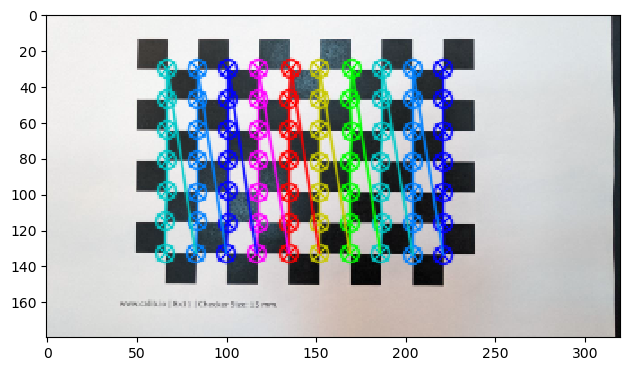

In [424]:
top_view_path = "images/top.jpg"
top_view = cv2.imread(top_view_path)
im_small = cv2.resize(top_view, None, fx=0.25, fy=0.25)

out = cv2.findChessboardCorners(im_small, (7, 10))

# Draw the corners
im_corners = im_small.copy()
cv2.drawChessboardCorners(im_corners, (7, 10), out[1], out[0])
io.imshow(im_corners)

In [425]:

for i, image in enumerate(images):  
    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(image, (7,10), None)

    if ret == False:
        print(i)


Chessboard corners can be detected for all images

## Ex 5.8

In [426]:
def checkerboard_points(n: int, m: int):
    """
    Generate a checkerboard of points from dimensions n and m
    Args:
        n (int): number of rows
        m (int): number of cols

    Return:
        board (np.array): checkerboard points
    """
    A = []
    for i in range(n):
        for j in range(m):
            A.append([i - (n - 1) // 2, j - (m - 1) // 2, 0])
    board = np.vstack(A).T
    return board

In [427]:
# 15 mm per between corners
checker_size = 15 / 1000
# Internal corners. 7 rows 10 columns
checkerboard = checkerboard_points(7, 10) * checker_size
print(checkerboard.shape) 
checkerboard[:2, :20], checkerboard[:2, -5:],
# 70 points, ordered by rows, first 10 points first row, next 10 points second row

(3, 70)


(array([[-0.045, -0.045, -0.045, -0.045, -0.045, -0.045, -0.045, -0.045,
         -0.045, -0.045, -0.03 , -0.03 , -0.03 , -0.03 , -0.03 , -0.03 ,
         -0.03 , -0.03 , -0.03 , -0.03 ],
        [-0.06 , -0.045, -0.03 , -0.015,  0.   ,  0.015,  0.03 ,  0.045,
          0.06 ,  0.075, -0.06 , -0.045, -0.03 , -0.015,  0.   ,  0.015,
          0.03 ,  0.045,  0.06 ,  0.075]]),
 array([[0.045, 0.045, 0.045, 0.045, 0.045],
        [0.015, 0.03 , 0.045, 0.06 , 0.075]]))

In [428]:
ret, corners = cv2.findChessboardCorners(im_small, (7,10), None)
# corners refer to all the 2d points on the chessboard
print(corners.shape)
corners[:20]
# corners[-10:]


(70, 1, 2)


array([[[221.03584 ,  30.40836 ]],

       [[221.13751 ,  47.436592]],

       [[221.06317 ,  64.511314]],

       [[221.06699 ,  81.76453 ]],

       [[221.01825 ,  98.962776]],

       [[221.27208 , 116.20755 ]],

       [[221.18843 , 133.64551 ]],

       [[203.87308 ,  30.37945 ]],

       [[203.86452 ,  47.331913]],

       [[203.94977 ,  64.50687 ]],

       [[203.82678 ,  81.69482 ]],

       [[203.9598  ,  98.89174 ]],

       [[203.97217 , 115.995674]],

       [[203.99239 , 133.56491 ]],

       [[186.55154 ,  30.49122 ]],

       [[186.6405  ,  47.377293]],

       [[186.58083 ,  64.503456]],

       [[186.45978 ,  81.671555]],

       [[186.47029 ,  98.7277  ]],

       [[186.54253 , 115.99933 ]]], dtype=float32)

In [429]:
oriented_checkerboard = np.zeros_like(checkerboard)
for i in range(7):  # 7 rows
    for j in range(10):  # 10 cols
        # Q[0] is out[6]
        # Q[1] is out[13]
        old_index = i * 10 + j
        new_index = j * 7 + (6 - i)
        oriented_checkerboard[:, new_index] = checkerboard[:, old_index]
oriented_checkerboard.shape, oriented_checkerboard[:2, :10]

((3, 70),
 array([[ 0.045,  0.03 ,  0.015,  0.   , -0.015, -0.03 , -0.045,  0.045,
          0.03 ,  0.015],
        [-0.06 , -0.06 , -0.06 , -0.06 , -0.06 , -0.06 , -0.06 , -0.045,
         -0.045, -0.045]]))

In [430]:
print(top_view.shape[:-1])

(720, 1280)


In [431]:
imgpoints= []
for i, image in enumerate(images):
    im_small = cv2.resize(image, None, fx=0.25, fy=0.25)
    ret, corners = cv2.findChessboardCorners(im_small, (7, 10), None)
    imgpoints.append(corners)

objpoints = [np.float32(oriented_checkerboard.T)] * len(imgpoints)  # List of 24 (70, 3) arrays

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
    objectPoints=objpoints,
    imagePoints=imgpoints,
    imageSize=im_small.shape[:-1],
    cameraMatrix=None,
    distCoeffs=None,
    flags=cv2.CALIB_FIX_K1
    + cv2.CALIB_FIX_K2
    + cv2.CALIB_FIX_K3
    + cv2.CALIB_FIX_K4
    + cv2.CALIB_FIX_K5
    + cv2.CALIB_FIX_K6
    + cv2.CALIB_ZERO_TANGENT_DIST,
)
mtx

array([[154.09398407,   0.        , 160.0314146 ],
       [  0.        , 154.08819275,  89.91829858],
       [  0.        ,   0.        ,   1.        ]])

## Ex 5.9

In [432]:
qs = np.array(imgpoints).reshape(len(imgpoints), 70, 2, 1)

In [433]:
Rs = []
ts = []
max_error = 0
for i in range(len(imgpoints)):
    R = np.eye(3)
    Rs.append(R)
    t = np.zeros((3, 1))
    cv2.Rodrigues(rvecs[i], R)
    t = tvecs[i].reshape(3,1)
    ts.append(t)
    K = mtx
    reprojected_point = Pi(projectpoints(K, R, t, oriented_checkerboard))
    # print(reprojected_point.shape, np.squeeze(qs[i].T).shape)
    max_error = max(max_error, np.linalg.norm(reprojected_point - np.squeeze(qs[i].T)))
print(f"max error is {max_error}")
Rs = np.array(Rs)
ts = np.array(ts)

max error is 5.029688898610549


## Ex 5.10

In [434]:
import itertools as it


def box3d(n=16):
    points = []
    N = tuple(np.linspace(-1, 1, n))
    for i, j in [(-1, -1), (-1, 1), (1, 1), (0, 0)]:
        points.extend(set(it.permutations([(i,) * n, (j,) * n, N])))
    return np.hstack(points) / 2
Q = (2 * box3d(8) + 1) * checker_size
Q.shape

(3, 120)

(3, 3) (3, 1)
(2, 120)


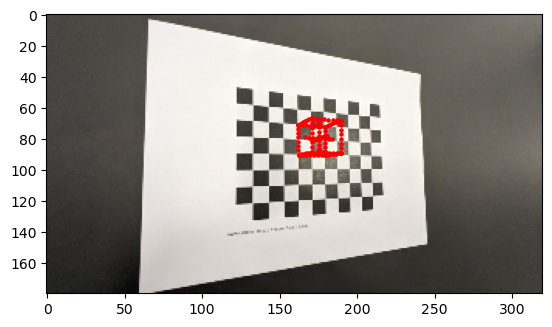

(3, 3) (3, 1)
(2, 120)


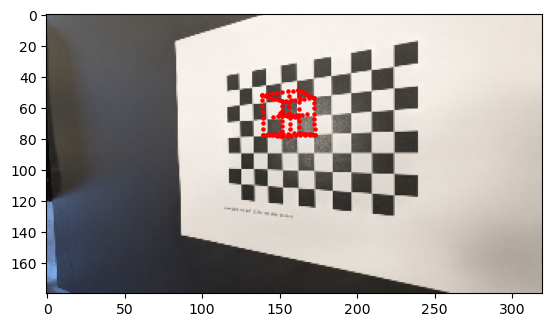

(3, 3) (3, 1)
(2, 120)


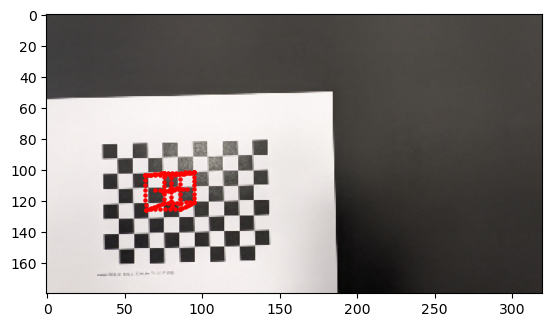

(3, 3) (3, 1)
(2, 120)


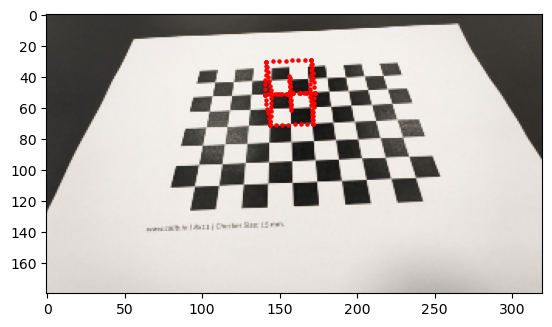

(3, 3) (3, 1)
(2, 120)


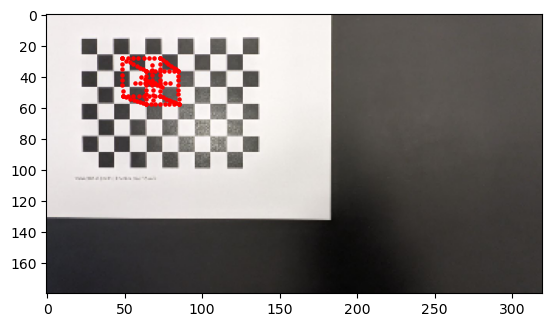

(3, 3) (3, 1)
(2, 120)


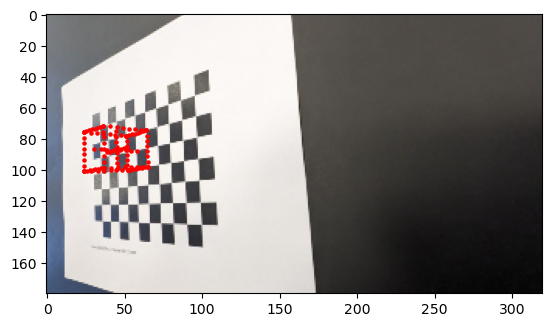

(3, 3) (3, 1)
(2, 120)


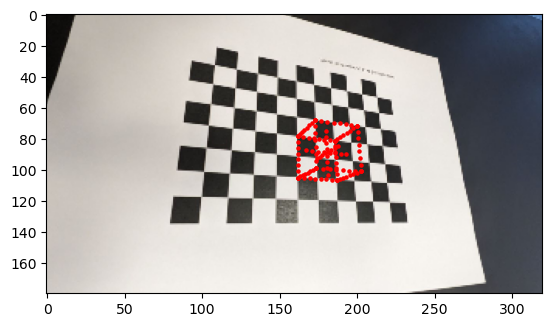

(3, 3) (3, 1)
(2, 120)


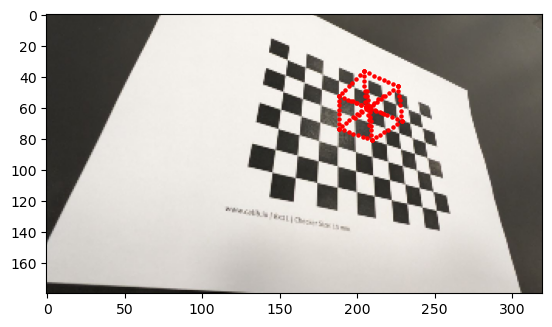

(3, 3) (3, 1)
(2, 120)


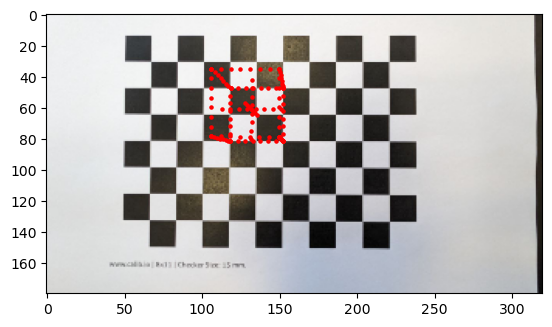

(3, 3) (3, 1)
(2, 120)


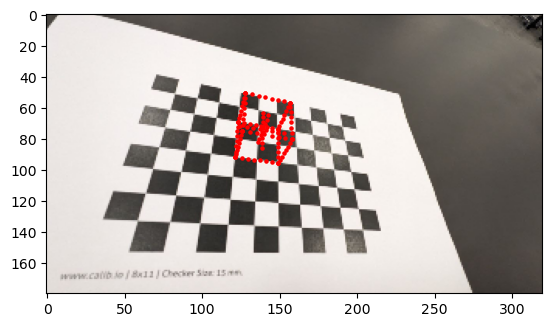

(3, 3) (3, 1)
(2, 120)


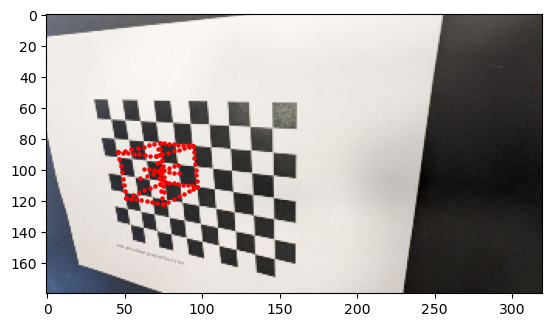

(3, 3) (3, 1)
(2, 120)


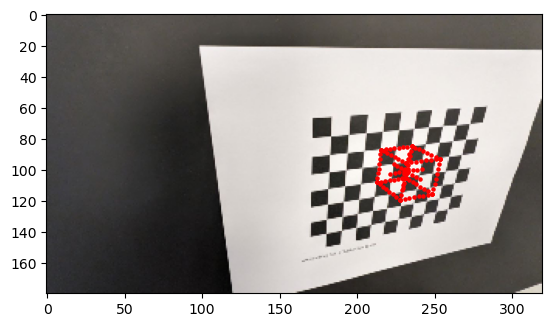

(3, 3) (3, 1)
(2, 120)


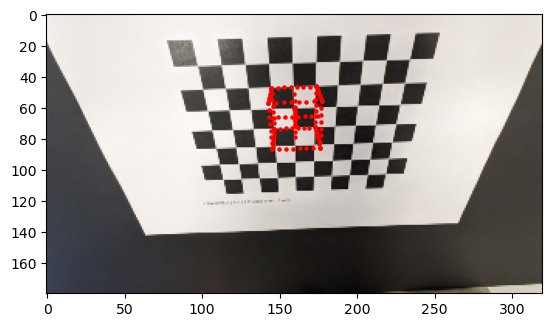

(3, 3) (3, 1)
(2, 120)


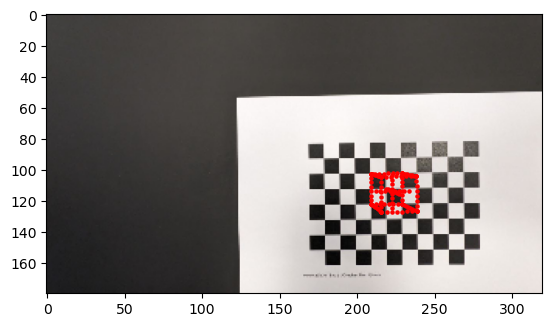

(3, 3) (3, 1)
(2, 120)


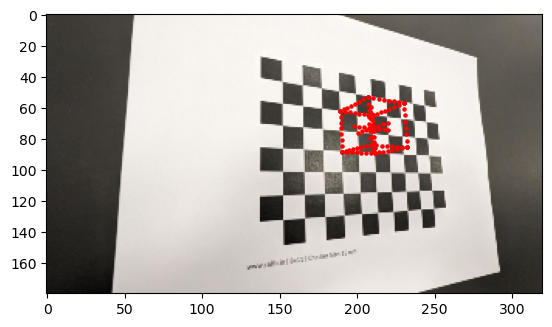

(3, 3) (3, 1)
(2, 120)


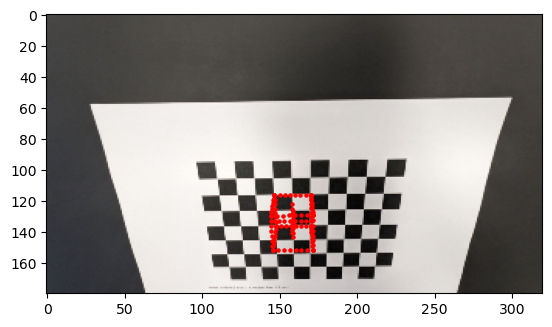

(3, 3) (3, 1)
(2, 120)


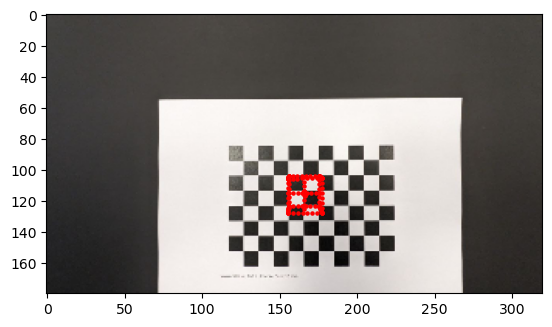

(3, 3) (3, 1)
(2, 120)


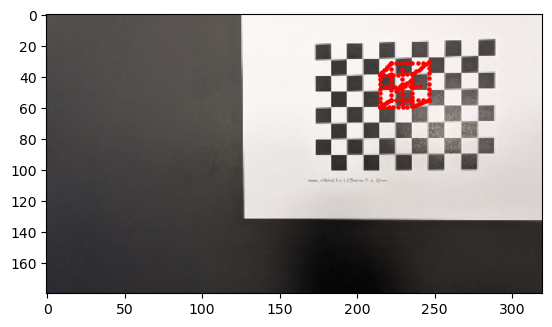

(3, 3) (3, 1)
(2, 120)


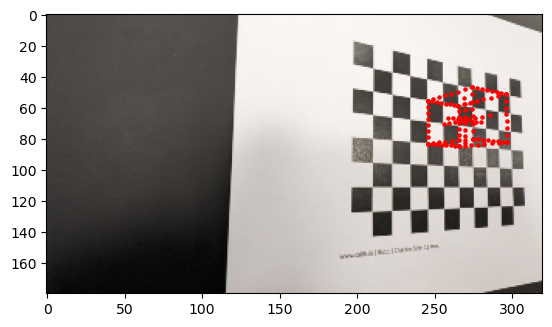

(3, 3) (3, 1)
(2, 120)


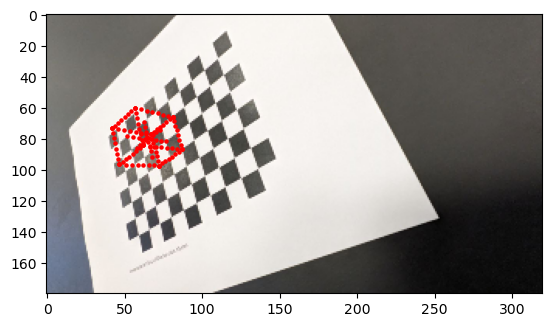

(3, 3) (3, 1)
(2, 120)


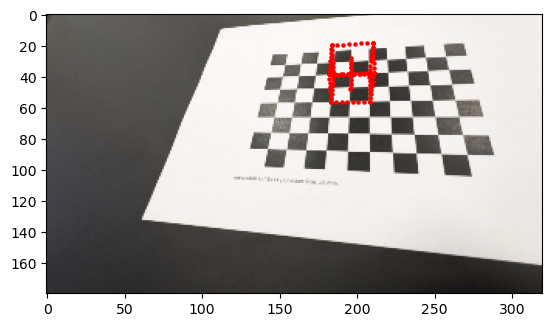

(3, 3) (3, 1)
(2, 120)


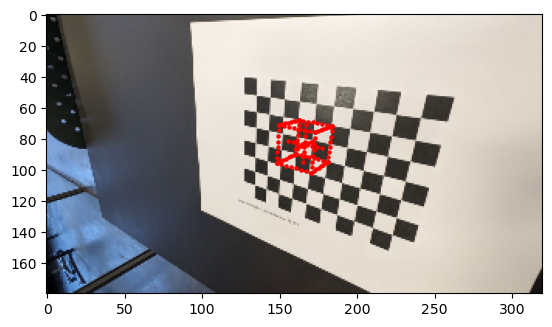

(3, 3) (3, 1)
(2, 120)


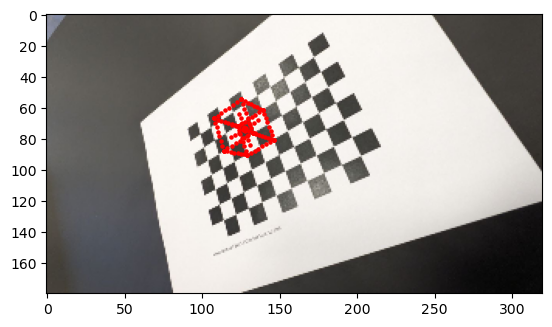

(3, 3) (3, 1)
(2, 120)


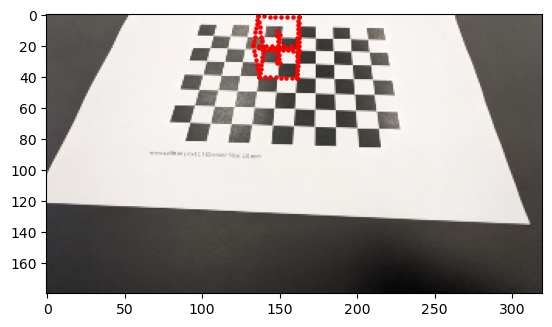

In [435]:
for i, image in enumerate(images):
    im_small = cv2.resize(image, None, fx=0.25, fy=0.25)
    print(Rs[i].shape, ts[i].shape)
    reprojected_box = Pi(projectpoints(mtx, Rs[i], ts[i], Q))
    print(reprojected_box.shape)
    plt.scatter(reprojected_box[0], reprojected_box[1], c="r", s=5)
    plt.imshow(cv2.cvtColor(im_small, cv2.COLOR_BGR2RGB))
    plt.show()

## Ex 5.11

In [436]:
imgpoints = []
for i, image in enumerate(images):
    im_small = cv2.resize(image, None, fx=0.25, fy=0.25)
    ret, corners = cv2.findChessboardCorners(im_small, (7, 10), None)
    imgpoints.append(corners)

objpoints = [np.float32(oriented_checkerboard.T)] * len(
    imgpoints
)  # List of 24 (70, 3) arrays

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
    objectPoints=objpoints,
    imagePoints=imgpoints,
    imageSize=im_small.shape[:-1],
    cameraMatrix=None,
    distCoeffs=None,
    flags=
    + cv2.CALIB_FIX_K2
    + cv2.CALIB_FIX_K3
    + cv2.CALIB_FIX_K4
    + cv2.CALIB_FIX_K5
    + cv2.CALIB_FIX_K6
    + cv2.CALIB_ZERO_TANGENT_DIST,
)
mtx

array([[154.14974811,   0.        , 160.07263624],
       [  0.        , 154.11826027,  89.87957124],
       [  0.        ,   0.        ,   1.        ]])

In [438]:
max_error = 0
for i in range(len(imgpoints)):
    R = np.eye(3)
    t = np.zeros((3, 1))
    cv2.Rodrigues(rvecs[i], R)
    t = tvecs[i].reshape(3, 1)
    K = mtx
    reprojected_point = Pi(projectpoints(K, R, t, oriented_checkerboard))
    # print(reprojected_point.shape, np.squeeze(qs[i].T).shape)
    max_error = max(max_error, np.linalg.norm(reprojected_point - np.squeeze(qs[i].T)))
print(f"max error is {max_error}")

max error is 5.151739619529753
